### Setup

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
from numpy.linalg import multi_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, silhouette_samples
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
from scipy.spatial.distance import pdist, squareform
from umap import UMAP
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [3]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

# Load data

## General data

In [4]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [5]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)
# Mapping gene to locus
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
# Mapping locus to gene
with open(saving_dir+'locus2gene.pkl', 'rb') as f:
    locus2gene = pickle.load(f)

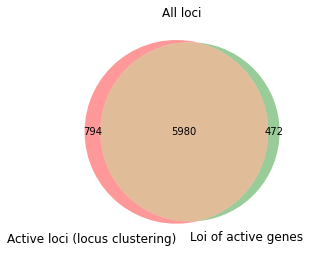

In [6]:
# Active/inactive loci (from clustering)
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)

# Active/inactive genes (from clustering)
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)

# Define active/inactive loci as the loci of active/inactive genes
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))
plt.figure()
venn2(subsets = (set(all_active_loci), set(all_active_loci_from_clustering)), 
      set_labels = ('Active loci (locus clustering)', 'Loi of active genes'))
plt.title('All loci')
plt.show()

# Redefine all active loci as the intersection between active loci determined directly by clustering'
# and all loci of active genes
all_active_loci = np.unique(list(set(all_active_loci).intersection(set(all_active_loci_from_clustering))))
all_inactive_loci = np.array(list(set(all_inactive_loci)-set(all_active_loci)))

In [7]:
# Adhesome genes and loci
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)

In [8]:
# Import list of all blacklisted loci
with open(dir_processed_hic+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

# Negative control

We are looking for active genes that
- Do not interact in Hi-C
- Have a low regulatory correlation

In [9]:
# Select all active non blacklisted loci that contain at least one gene
loci_containing_genes = np.unique(list(itertools.chain.from_iterable(list(gene2locus.values()))))
selected_active_loci = np.unique(list(set(all_active_loci).intersection(set(loci_containing_genes))
                                      -set(blacklist_list)))
print(f'Number of selected active loci = {len(selected_active_loci)}')

Number of selected active loci = 5623


In [10]:
# Load Hi-C proximity matrix and scale it
with open(saving_dir+f'contacts_df_negcontrol_{norm}.pkl', 'rb') as f:
    contacts_df1 = pickle.load(f)
max_val = contacts_df1.max().max()
contacts_df1 = contacts_df1/max_val

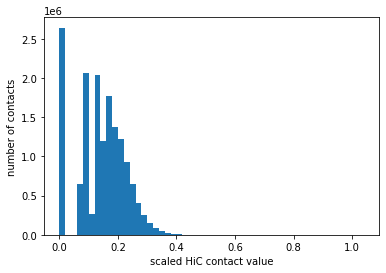

In [13]:
# Plot distribution of Hi-C values
hic_contacts = contacts_df1.values
y_hic = hic_contacts[np.triu_indices(n=len(hic_contacts),k=1)]
hic_threshold = 0
plt.figure()
plt.hist(y_hic, bins=np.arange(0,1.05, 0.02))
#plt.yscale('log')
plt.xlabel('scaled HiC contact value')
plt.ylabel('number of contacts')
plt.show()
# Loci that are far apart in HiC
selected_hic_df = (contacts_df1<=hic_threshold).astype(int)
np.fill_diagonal(selected_hic_df.values, 0)

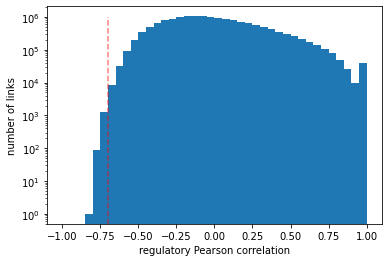

In [14]:
# Loci that are far apart in coregulation
df_allloci_norm = pd.read_csv(saving_dir+'features_matrix_all_loci_norm.csv', header=0, index_col=0)
selected_df = df_allloci_norm.loc[:, selected_active_loci]
selected_corr_df0 = selected_df.corr(method='pearson')
reg_contacts = selected_corr_df0.values
y_reg = reg_contacts[np.triu_indices(n=len(reg_contacts),k=1)]
reg_threshold = -0.7
plt.figure()
plt.hist(y_reg, bins=np.arange(-1,1.05, 0.05))
plt.vlines(x=reg_threshold, ymin=0, ymax=1e6, color='red', linestyle='dashed', alpha=0.5)
plt.yscale('log')
plt.xlabel('regulatory Pearson correlation')
plt.ylabel('number of links')
plt.show()
# Loci that are far apart in HiC
selected_corr_df = (selected_corr_df0<=reg_threshold).astype(int)
np.fill_diagonal(selected_corr_df.values, 0)

In [15]:
# Loci that are far apart in both HiC and regulatory marks
combined_df = selected_hic_df*selected_corr_df
nonzero_vals = np.where(combined_df)
negative_controls_df = pd.DataFrame({'locus1': combined_df.index.values[nonzero_vals[0]],
                                     'locus2': combined_df.index.values[nonzero_vals[1]]})
negative_controls_df['chr1'] = negative_controls_df['locus1'].str.split('_', expand=True)[1].astype(int)
negative_controls_df['chr2'] = negative_controls_df['locus2'].str.split('_', expand=True)[1].astype(int)
negative_controls_df['hic'] =  [contacts_df1.loc[negative_controls_df.iloc[i,0], negative_controls_df.iloc[i,1]] 
                                for i in range(len(negative_controls_df))]
negative_controls_df['corr'] =  [selected_corr_df0.loc[negative_controls_df.iloc[i,0], negative_controls_df.iloc[i,1]] 
                                     for i in range(len(negative_controls_df))]
negative_controls_df['genes_locus1'] = [locus2gene[negative_controls_df.iloc[i]['locus1']] 
                                        for i in range(len(negative_controls_df))]
negative_controls_df['genes_locus2'] = [locus2gene[negative_controls_df.iloc[i]['locus2']] 
                                        for i in range(negative_controls_df.shape[0])]
negative_controls_df

,locus1,locus2,chr1,chr2,hic,corr,genes_locus1,genes_locus2
0,chr_10_loc_113750000,chr_6_loc_133250000,10,6,0.0,-0.716385,[GPAM],[LINC00326]
1,chr_10_loc_119750000,chr_10_loc_23500000,10,10,0.0,-0.728377,"[CASC2, RAB11FIP2]","[C10ORF67, OTUD1]"
2,chr_10_loc_120250000,chr_12_loc_51500000,10,12,0.0,-0.704234,"[CACUL1, PRLHR]","[BIN2, CELA1, DAZAP2, GALNT6, LOC494150, POU6F..."
3,chr_10_loc_124000000,chr_4_loc_16750000,10,4,0.0,-0.731223,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]",[LDB2]
4,chr_10_loc_129000000,chr_20_loc_21000000,10,20,0.0,-0.700566,[DOCK1],"[BC034426, BC042893, PLK1S1]"
...,...,...,...,...,...,...,...,...
479,chr_9_loc_3500000,chr_6_loc_102000000,9,6,0.0,-0.753257,[RFX3],[GRIK2]
480,chr_9_loc_4000000,chr_9_loc_13000000,9,9,0.0,-0.724026,[GLIS3],[MPDZ]
481,chr_9_loc_4000000,chr_9_loc_137250000,9,9,0.0,-0.736811,[GLIS3],"[MIR4669, RXRA]"
482,chr_9_loc_80000000,chr_2_loc_222250000,9,2,0.0,-0.730160,"[GNA14, VPS13A]","[AX747413, EPHA4]"


In [16]:
# Filter out pairs containing loci on chromosomes 1, 8, 9, 11, 16, 17, 19
chrom2exclude = [1, 8, 9, 11, 16, 17, 19]
negative_controls_df = negative_controls_df[(~negative_controls_df['chr1'].isin(chrom2exclude)) &
                                            (~negative_controls_df['chr2'].isin(chrom2exclude))]
negative_controls_df

,locus1,locus2,chr1,chr2,hic,corr,genes_locus1,genes_locus2
0,chr_10_loc_113750000,chr_6_loc_133250000,10,6,0.0,-0.716385,[GPAM],[LINC00326]
1,chr_10_loc_119750000,chr_10_loc_23500000,10,10,0.0,-0.728377,"[CASC2, RAB11FIP2]","[C10ORF67, OTUD1]"
2,chr_10_loc_120250000,chr_12_loc_51500000,10,12,0.0,-0.704234,"[CACUL1, PRLHR]","[BIN2, CELA1, DAZAP2, GALNT6, LOC494150, POU6F..."
3,chr_10_loc_124000000,chr_4_loc_16750000,10,4,0.0,-0.731223,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]",[LDB2]
4,chr_10_loc_129000000,chr_20_loc_21000000,10,20,0.0,-0.700566,[DOCK1],"[BC034426, BC042893, PLK1S1]"
...,...,...,...,...,...,...,...,...
444,chr_7_loc_87750000,chr_7_loc_111000000,7,7,0.0,-0.716478,"[ADAM22, SRI, STEAP4]",[IMMP2L]
445,chr_7_loc_87750000,chr_7_loc_114000000,7,7,0.0,-0.715647,"[ADAM22, SRI, STEAP4]",[FOXP2]
446,chr_7_loc_87750000,chr_7_loc_130750000,7,7,0.0,-0.730090,"[ADAM22, SRI, STEAP4]","[AK054623, FLJ43663]"
447,chr_7_loc_87750000,chr_7_loc_28000000,7,7,0.0,-0.725341,"[ADAM22, SRI, STEAP4]","[JAZF1, JAZF1-AS1]"


In [17]:
# Filter out pairs containing loci on same chromosome
negative_controls_df = negative_controls_df[negative_controls_df['chr1'] != negative_controls_df['chr2']]
negative_controls_df

,locus1,locus2,chr1,chr2,hic,corr,genes_locus1,genes_locus2
0,chr_10_loc_113750000,chr_6_loc_133250000,10,6,0.0,-0.716385,[GPAM],[LINC00326]
2,chr_10_loc_120250000,chr_12_loc_51500000,10,12,0.0,-0.704234,"[CACUL1, PRLHR]","[BIN2, CELA1, DAZAP2, GALNT6, LOC494150, POU6F..."
3,chr_10_loc_124000000,chr_4_loc_16750000,10,4,0.0,-0.731223,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]",[LDB2]
4,chr_10_loc_129000000,chr_20_loc_21000000,10,20,0.0,-0.700566,[DOCK1],"[BC034426, BC042893, PLK1S1]"
5,chr_10_loc_17750000,chr_3_loc_112750000,10,3,0.0,-0.710322,"[MRC1, STAM]",[BOC]
...,...,...,...,...,...,...,...,...
435,chr_7_loc_27000000,chr_13_loc_48500000,7,13,0.0,-0.703888,"[BC035889, HOTAIRM1, HOTTIP, HOXA-AS3, HOXA-AS...","[MED4, MED4-AS1, NUDT15, SUCLA2]"
436,chr_7_loc_28000000,chr_2_loc_223750000,7,2,0.0,-0.717204,"[JAZF1, JAZF1-AS1]","[ACSL3, KCNE4]"
437,chr_7_loc_28000000,chr_3_loc_3000000,7,3,0.0,-0.717417,"[JAZF1, JAZF1-AS1]","[CNTN4, CRBN, IL5RA, TRNT1]"
440,chr_7_loc_74000000,chr_6_loc_102000000,7,6,0.0,-0.721194,"[BC070376, GTF2I, GTF2IRD1, GTF2IRD2]",[GRIK2]


In [18]:
# Construct list of adjacent triplets
loci_set_list = []
for i in tqdm(range(len(negative_controls_df))):
    node1 = negative_controls_df.iloc[i]['locus1']
    node2 = negative_controls_df.iloc[i]['locus2']
    
    for j in range(i+1, len(negative_controls_df)):
        node3 = negative_controls_df.iloc[j]['locus1']
        node4 = negative_controls_df.iloc[j]['locus2']
        
        if (node1==node3) & (node2.split('_')[1]!=node4.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node1==node4) & (node2.split('_')[1]!=node3.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node2==node3) & (node1.split('_')[1]!=node4.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node2==node4) & (node1.split('_')[1]!=node3.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
loci_set_list = np.unique(loci_set_list, axis=0)

100%|██████████| 160/160 [00:05<00:00, 28.42it/s]


In [19]:
# Add metadata
pd.set_option('max_colwidth', 400)
final_loci_df = pd.DataFrame({'loci_set': list(loci_set_list)})

# Pairwise Hi-C contact among loci
pairwise_hic_values = []
pairwise_hic_within = []
for loci in final_loci_df['loci_set']:
    pairwise_hic_values.append(contacts_df1.loc[loci, loci].values[np.triu_indices(len(loci), 1)])
    pairwise_hic_within.append(np.max(contacts_df1.loc[loci, loci].values[np.triu_indices(len(loci), 1)]))
final_loci_df['hic_values'] = pairwise_hic_values
final_loci_df['hic_strength'] = pairwise_hic_within

# Pairwise coregulation among loci
pairwise_reg_values = []
pairwise_reg_within = []
for loci in final_loci_df['loci_set']:
    pairwise_reg_values.append(selected_corr_df0.loc[loci, loci].values[np.triu_indices(len(loci), 1)])
    pairwise_reg_within.append(np.max(selected_corr_df0.loc[loci, loci].values[np.triu_indices(len(loci), 1)]))
final_loci_df['reg_values'] = pairwise_reg_values
final_loci_df['reg_strength'] = pairwise_reg_within

# Average Hi-C contact with selected adhesome loci
selected_adhesome_genes = ['SHARPIN', 'HRAS', 'SLC16A3', 
                           'CD151', 'PLEC', 'UBE2I', 
                           'CFL1', 'PIP5K1C', 'PKD1', 
                           'SHC1', 'TESK1', 'TLN1']
selected_adhesome_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] 
                                                                      for g in selected_adhesome_genes])))
hic_to_closest_adhesome = []
average_hic_to_adhesome = []
for loci in final_loci_df['loci_set']:
    hic_to_closest_adhesome.append(contacts_df1.loc[loci, selected_adhesome_loci].max().max())
    average_hic_to_adhesome.append(contacts_df1.loc[loci, selected_adhesome_loci].mean().mean())
final_loci_df['hic_to_closest_adhesome'] = hic_to_closest_adhesome
final_loci_df['average_hic_to_adhesome'] = average_hic_to_adhesome

# Average coregulation with adhesome loci
reg_to_closest_adhesome = []
average_reg_to_adhesome = []
for loci in final_loci_df['loci_set']:
    reg_to_closest_adhesome.append(selected_corr_df0.loc[loci, selected_adhesome_loci].max().max())
    average_reg_to_adhesome.append(selected_corr_df0.loc[loci, selected_adhesome_loci].mean().mean())
final_loci_df['reg_to_closest_adhesome'] = reg_to_closest_adhesome
final_loci_df['average_reg_to_adhesome'] = average_hic_to_adhesome

final_loci_df = final_loci_df.sort_values(['hic_strength', 'reg_strength'], ascending=[True, True])
final_loci_df

,loci_set,hic_values,hic_strength,reg_values,reg_strength,hic_to_closest_adhesome,average_hic_to_adhesome,reg_to_closest_adhesome,average_reg_to_adhesome
69,"[chr_15_loc_31750000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7089629776260304, 0.6631244192608599, -0.7211944974439696]",0.663124,0.373970,0.169479,0.842617,0.169479
88,"[chr_2_loc_10500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6791738755011261, -0.7338893332708432, -0.7401521128984191]",0.679174,0.355289,0.138919,0.739706,0.138919
106,"[chr_3_loc_56500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6892924795724544, -0.7295212180025412, -0.7401521128984191]",0.689292,0.203137,0.105991,0.739706,0.105991
100,"[chr_2_loc_87000000, chr_3_loc_100250000, chr_5_loc_122750000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7279423539358837, -0.700168412219138, 0.6993719830096027]",0.699372,0.265075,0.152152,0.876837,0.152152
109,"[chr_4_loc_166250000, chr_5_loc_157250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.7031155945424487, -0.7401521128984191, -0.7665475158423825]",0.703116,0.271932,0.103766,0.814451,0.103766
...,...,...,...,...,...,...,...,...,...
55,"[chr_14_loc_73500000, chr_3_loc_47750000, chr_6_loc_102000000]","[0.27186989944377343, 0.0, 0.0]",0.271870,"[0.7571124136914913, -0.8076662488432128, -0.7184103278918818]",0.757112,0.354895,0.216203,0.922564,0.216203
19,"[chr_12_loc_51000000, chr_3_loc_47750000, chr_6_loc_102000000]","[0.30667903180376915, 0.0, 0.0]",0.306679,"[0.830041215147353, -0.720346328453393, -0.7184103278918818]",0.830041,0.354895,0.230747,0.922564,0.230747
105,"[chr_3_loc_47750000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.3307182347896831, 0.0]",0.330718,"[-0.7184103278918818, 0.8315192051211653, -0.7211944974439696]",0.831519,0.373970,0.235114,0.922564,0.235114
59,"[chr_14_loc_73500000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.33360713949774007, 0.0]",0.333607,"[-0.8076662488432128, 0.81194122007367, -0.7211944974439696]",0.811941,0.373970,0.212950,0.842617,0.212950


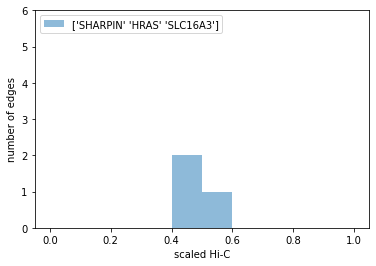

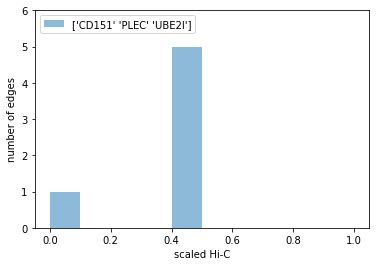

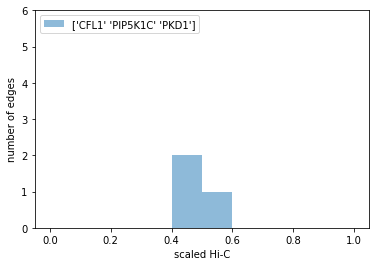

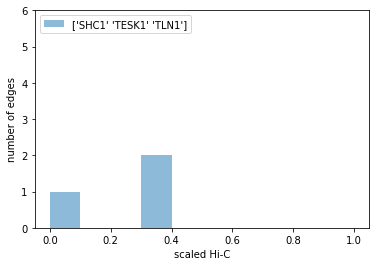

In [20]:
# Histogram of HiC for the positive validation sets
validation_sets = np.array([['SHARPIN', 'HRAS', 'SLC16A3'],['CD151', 'PLEC', 'UBE2I'],
                   ['CFL1', 'PIP5K1C', 'PKD1'], ['SHC1', 'TESK1', 'TLN1']])

for valset in validation_sets:
    val_loci = np.array(list(itertools.chain.from_iterable([gene2locus[g] for g in valset])))
    x = contacts_df1.loc[val_loci, val_loci].values
    plt.figure()
    plt.hist(x[np.triu_indices(len(x), 1)],  bins=np.arange(0,1.1, 0.1), alpha=0.5, label=str(valset))
    plt.legend(loc='upper left')
    plt.ylim([0,6])
    plt.xlabel('scaled Hi-C')
    plt.ylabel('number of edges')
    plt.show()

In [23]:
# Select promising triplets
selected_final_loci_df = final_loci_df[(final_loci_df['hic_strength']<0.1) &
                          (final_loci_df['hic_to_closest_adhesome']<0.25)]
selected_final_loci_df.to_csv(saving_dir+'selected_negative_control_loci.csv', sep=';', header=True)
selected_final_loci_df

,loci_set,hic_values,hic_strength,reg_values,reg_strength,hic_to_closest_adhesome,average_hic_to_adhesome,reg_to_closest_adhesome,average_reg_to_adhesome
106,"[chr_3_loc_56500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6892924795724544, -0.7295212180025412, -0.7401521128984191]",0.689292,0.203137,0.105991,0.739706,0.105991
94,"[chr_2_loc_160000000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.7909965735916539, -0.7510283778917214, -0.7401521128984191]",0.790997,0.229282,0.118639,0.858377,0.118639
1,"[chr_10_loc_124000000, chr_2_loc_159500000, chr_4_loc_16750000]","[0.0, 0.0, 0.0]",0.000000,"[0.8358840393060243, -0.7312233085302212, -0.7102909604785693]",0.835884,0.249406,0.119095,0.858349,0.119095
80,"[chr_20_loc_52500000, chr_2_loc_222250000, chr_3_loc_61500000]","[0.0, 0.0, 0.0]",0.000000,"[-0.70833458536473, 0.8867799889918916, -0.7062601486673616]",0.886780,0.234522,0.130122,0.859443,0.130122
91,"[chr_2_loc_159500000, chr_4_loc_16750000, chr_6_loc_126750000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7102909604785693, 0.9314319947187585, -0.7123071690729694]",0.931432,0.249406,0.113263,0.858349,0.113263
2,"[chr_10_loc_124000000, chr_2_loc_160000000, chr_4_loc_16750000]","[0.07998214476792433, 0.0, 0.0]",0.079982,"[0.8112318744080471, -0.7312233085302212, -0.7031631241237828]",0.811232,0.236208,0.142112,0.858377,0.142112
95,"[chr_2_loc_160000000, chr_4_loc_16750000, chr_6_loc_102000000]","[0.0, 0.0, 0.08526728789352736]",0.085267,"[-0.7031631241237828, -0.7510283778917214, 0.6514411682199357]",0.651441,0.236208,0.132256,0.858377,0.132256
3,"[chr_10_loc_124000000, chr_4_loc_16750000, chr_6_loc_126750000]","[0.0, 0.09428316806123702, 0.0]",0.094283,"[-0.7312233085302212, 0.7908114438239033, -0.7123071690729694]",0.790811,0.236208,0.124098,0.852303,0.124098


In [22]:
# Display genes of final selected loci
selected_final_loci_list = np.unique(list(itertools.chain.from_iterable(selected_final_loci_df['loci_set'])))
pd.DataFrame({'locus': selected_final_loci_list,
              'genes': [locus2gene[loc] for loc in selected_final_loci_list]})

,locus,genes
0,chr_10_loc_124000000,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]"
1,chr_20_loc_52500000,"[BCAS1, MIR4756]"
2,chr_2_loc_159500000,"[AK126351, DAPL1, PKP4]"
3,chr_2_loc_160000000,"[BAZ2B, TANC1, WDSUB1]"
4,chr_2_loc_222250000,"[AX747413, EPHA4]"
5,chr_3_loc_56500000,"[CCDC66, ERC2, FAM208A]"
6,chr_3_loc_61500000,[PTPRG]
7,chr_4_loc_166250000,"[CPE, JA611274, MIR578, MSMO1]"
8,chr_4_loc_16750000,[LDB2]
9,chr_6_loc_102000000,[GRIK2]
